In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
import time
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from lib.net import GNN_Net
from lib.pytorchtools import EarlyStopping, check_gpu

/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Define Main Loop for GNN Training

In [2]:
def main(train_data_dir):

    ####  1. Training Parameter Setting  ####

    LR = 0.0015  ## learning rate

    epoch_num = 200  ## epoch number

    batch_size = 512  ## batch size

    patience = 30  ## early_stopping patience

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ## device defination

    model = GNN_Net().to(device)  ## GNN model loading

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)  ## optimizer setting

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True,
                                                           threshold=0.001, threshold_mode='rel',
                                                           cooldown=0, min_lr=0, eps=1e-08)  ## learning rate adapter setting

    criterion = nn.L1Loss()  ## MAE Loss

    early_stopping = EarlyStopping(patience=patience, verbose=True)  ## initialize the early_stopping object

    history = {
        "train_loss": [],
        "train_time": [],
        "val_loss": [],
    }  ## training history recording


    ####  2. Dataset Loading  ####

    graph_list_dir = os.path.join(train_data_dir, 'Ben_Train_val_data_list.pt')  ## train/val set dir
    graph_list = torch.load(graph_list_dir)  ## load voronoi graph dataset
    np.random.shuffle(graph_list)  ## shuffle the dataset
    np.random.shuffle(graph_list)  ## shuffle the dataset

    train_size = int(len(graph_list) * 0.8)   ## train set size
    val_size = int(len(graph_list) * 0.2)   ## validation set size

    trainset = graph_list[:train_size]  
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)  ## training dataset

    valset = graph_list[train_size:train_size + val_size]  
    validloader = DataLoader(valset, batch_size=batch_size, shuffle=True, drop_last=True)  ## validation dataset


    ####  3. Start Training   ####
    
    print('Start Train')
    
    erro = 10000  ## initialise error value to max
    pose_2_norm = 1  ## pose_2 norm scale
    pose_6_norm = 1  ## pose_6 norm scale

    for epoch in range(epoch_num):  ## start an epoch...
        
        start = time.time()
        train_loss = 0.0
        train_total = 0
        train_batch_num = 0.0

        ## Train loop
        for i, batch in enumerate(trainloader):  ## start a batch...

            model.train()  ## set as traning mode
            
            batch = batch.to(device)  ## load batch data

            optimizer.zero_grad()  ## gradiant clear

            outputs = model(batch)  ## GNN model prediction output

            out_norm = outputs*torch.tensor([pose_2_norm,pose_6_norm]).to(device) ## output normalization

            label_norm = (batch.y).view(outputs.size())*torch.tensor([pose_2_norm,pose_6_norm]).to(device)  ## target normalization

            loss = criterion(out_norm, label_norm)  ## calculate loss    

            loss.backward()  ## backward

            optimizer.step()  ## parameter update bt optimizer

            train_loss += loss.cpu().item()  ## Loss add

            train_total += 1  ## update train times 

            train_batch_num += 1  ## update batch number 

            if i % 10 == 9:
                progress_bar = '[' + ('=' * ((i + 1) // 10)) + (' ' * ((train_size // 100 - (i + 1)) // 10)) + ']'
                print('\repoch: {:d} training loss: {:.5f} {}'
                      .format(epoch + 1, loss.cpu().item(), progress_bar), end="  ")  ## live Loss

        time_cost = time.time() - start
        
        print('\repoch: {:d} train loss: {:.5f} training time: {:.1f} s/epoch'
              .format(epoch + 1, train_loss / (train_size / batch_size), time_cost), end="  ")  # current epoch avrage Loss of each batch

        history["train_loss"].append(train_loss / (train_size / batch_size))  ## record train loss
        history["train_time"].append(time_cost)   ## record train time cost


        ####  4. Start Validation  ####

        model.eval()  ## set as evaluation mode, to make traning smoother and faster, may just note and ignore it

        val_batch_num = 0
        val_loss = 0
        
        ## Validation loop
        with torch.no_grad():  ## stop gradiant update

            for data in validloader: 

                data = data.to(device)  ## load batch data

                outputs = model(data)  ## GNN model prediction output

                out_norm = outputs*torch.tensor([pose_2_norm, pose_6_norm]).to(device)

                label_norm = (data.y).view(outputs.size())*torch.tensor([pose_2_norm,pose_6_norm]).to(device)

                val_loss += criterion(out_norm, label_norm)  ## Valid Loss

                val_batch_num += 1

        history["val_loss"].append(float(val_loss / val_batch_num))  ## record val loss

        print(f'Valid Loss: {val_loss / val_batch_num:.5f}', end='  ')  ## val loss

        scheduler.step(loss.cpu().item() / val_batch_num)  # learning rate update

        LR_ = optimizer.param_groups[0]['lr']  ## new learning rate

        print('\n' + f'learning rate: {LR_:.8f}', end='  ')  

        if (val_loss / val_batch_num) < erro:  ## save the best model from all epoch

            erro = val_loss / val_batch_num

            model_dir = train_data_dir + '/Ben_best_model.pth'

            torch.save(model.state_dict(), model_dir)   

            print('\n' + 'Saving model......' + '\n')
            
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print('\n' + 'Early stopping')
            break

    # load the last checkpoint with the best model
    # model.load_state_dict(torch.load('checkpoint.pt'))
    
    print('\n' + 'Finished Training')
    

    ####  5. Save Training Results  ####
    
    ## visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(history["train_loss"])+1),history["train_loss"], label='Training Loss')
    plt.plot(range(1,len(history["val_loss"])+1),history["val_loss"],label='Validation Loss')
    
    ## find position of lowest validation loss
    minposs = history["val_loss"].index(min(history["val_loss"]))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, history["train_loss"][0]*1.2) # consistent scale
    plt.xlim(0, len(history["train_loss"])+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ## save the loss plot
    fig.savefig(train_data_dir + '/Ben_loss_plot' + '.png', bbox_inches='tight')

## 2. Run Main Loop for GNN Training

/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Start Train
epoch: 1 train loss: 4.75556 training time: 16.6 s/epoch  Valid Loss: 5.75723  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (inf --> 5.757232).  Saving model ...
epoch: 2 train loss: 4.13476 training time: 16.5 s/epoch  Valid Loss: 5.83255  
learning rate: 0.00150000  EarlyStopping counter: 1 out of 30

epoch: 3 train loss: 3.75488 training time: 16.2 s/epoch  Valid Loss: 5.49902  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (5.757232 --> 5.499016).  Saving model ...
epoch: 4 train loss: 3.44722 training time: 16.6 s/epoch  Valid Loss: 5.50518  
learning rate: 0.00150000  EarlyStopping counter: 1 out of 30

epoch: 5 train loss: 3.19034 training time: 16.3 s/epoch  Valid Loss: 5.48039  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (5.499016 --> 5.480389).  Saving model ...
epoch: 6 train loss: 3.01492 training time: 16.4 s/epoch  Valid Loss: 5.31640  
learning rate: 0.00150000  
Saving m

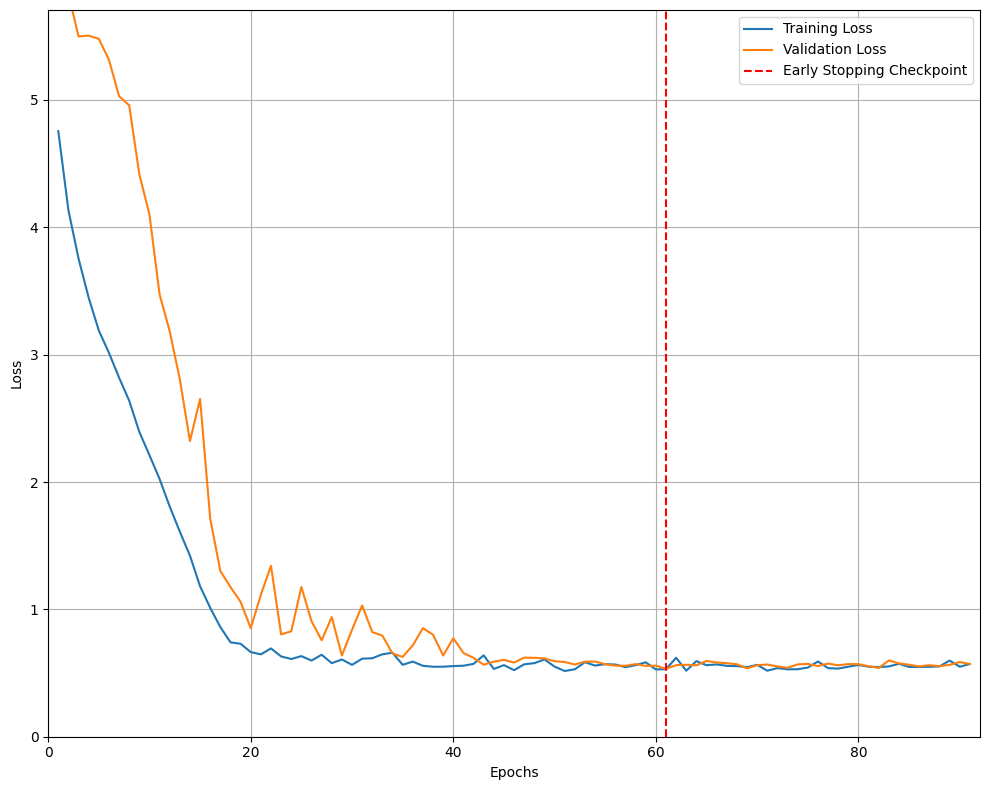

In [3]:
train_data_dir = r'../result/train'  ## train data dir

# check_gpu(0)  ## set gpu device id

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  ## allow duplicate load DLL

if __name__ == "__main__":
    
    main(train_data_dir)